In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [ ]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
h = 1e-3  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 40

# Set the diffusion coefficient
sigma = 1.09

In [9]:
print('lag time: ', lag_time)

lag time:  0.1


In [3]:
# # Generate linspace for x and y coordinates
# x_values = np.linspace(-2, 2, m)
# y_values = np.linspace(-1, 2, m)

# # Create a meshgrid from these linspace arrays
# xx, yy = np.meshgrid(x_values, y_values)

# # Flatten the meshgrid matrices to get the coordinate pairs
# x0_values = xx.flatten()
# y0_values = yy.flatten()

# # Initialize the data_matrix
# data_matrix = np.zeros((m**2, n_eval+1, 2))

# # Generate trajectories for each selected point
# for i in tqdm (range(m**2)):
#     x = x0_values[i]
#     y = y0_values[i]
    
#     for j in range(n_eval+1):
#         data_matrix[i, j, 0] = x
#         data_matrix[i, j, 1] = y
        
#         for k in range(n_steps):
#             dVdx, dVdy = gradient(x, y)
#             x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
#             y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# # Create a grid of points
# x_plot = np.linspace(-2, 2, 100)
# y_plot = np.linspace(-1, 2, 100)
# X, Y = np.meshgrid(x_plot, y_plot)

In [4]:
# ## Save the data to local folder
# # Create a folder to store the data (if it doesn't exist)
# folder_path = "data"
# os.makedirs(folder_path, exist_ok=True)

# # Save the data_matrix to a file
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# np.save(file_path, data_matrix)

In [5]:
## load the data from local folder
import os
# Load the data_matrix from the file
folder_path = "data"
file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
data_matrix = np.load(file_path)
data_matrix.shape

(1600, 11, 2)

In [6]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

checkpoint_file= 'well2d_example_ckpt004.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[15], n_psi_train=12).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
# kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K

outputs = {
    'efuns': efuns,
    'evalues': evalues,
    # 'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    # 'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Shape of data_X: (1600, 10, 2)
Shape of data_Y: (1600, 10, 2)
Shape of X: (16000, 2)
Shape of Y: (16000, 2)
(11200, 2)
Epoch: 1 	Training Loss: 0.721905 val loss: 0.702581
saving, val loss enhanced: 0.7025808389571188 10000
Epoch: 2 	Training Loss: 0.664682 val loss: 0.644910
saving, val loss enhanced: 0.6449102991039439 0.7025808389571188
Epoch: 3 	Training Loss: 0.606707 val loss: 0.586002
saving, val loss enhanced: 0.5860018637828882 0.6449102991039439
Epoch: 4 	Training Loss: 0.550463 val loss: 0.531735
saving, val loss enhanced: 0.5317353693669998 0.5860018637828882
Epoch: 5 	Training Loss: 0.496982 val loss: 0.477374
saving, val loss enhanced: 0.47737369086395703 0.5317353693669998
Epoch: 6 	Training Loss: 0.446905 val loss: 0.429388
saving, val loss enhanced: 0.4293883391182316 0.47737369086395703
Epoch: 7 	Training Loss: 0.400725 val loss: 0.385485
saving, val loss enhanced: 0.3854853495388223 0.4293883391182316
Epoch: 8 	Training Loss: 0.358398 val loss: 0.344107
saving, val l

Computing dPsi_X: 100%|██████████| 167985/167985 [00:38<00:00, 4340.82iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Outer Epoch 1/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:40<00:00, 4107.36iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 40.595453 val loss: 149.175445
saving, val loss enhanced: 149.17544536306306 1000000000000000.0
Epoch: 2 	Training Loss: 40.346472 val loss: 148.665053
saving, val loss enhanced: 148.66505286605766 149.17544536306306
Epoch: 3 	Training Loss: 40.109078 val loss: 148.171431
saving, val loss enhanced: 148.17143093844885 148.66505286605766
Epoch: 4 	Training Loss: 39.875194 val loss: 147.686115
saving, val loss enhanced: 147.68611498533733 148.17143093844885
Epoch 1 time: 63.02 seconds
Outer Epoch 2/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:42<00:00, 3949.82iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 41.113500 val loss: 149.427483
Epoch: 2 	Training Loss: 40.869252 val loss: 148.948047
Epoch: 3 	Training Loss: 40.628204 val loss: 148.472843
Epoch: 4 	Training Loss: 40.390247 val loss: 148.001183
Epoch 2 time: 65.14 seconds
Outer Epoch 3/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:45<00:00, 3700.35iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 41.243590 val loss: 145.832634
saving, val loss enhanced: 145.83263401118725 147.68611498533733
Epoch: 2 	Training Loss: 41.002640 val loss: 145.398163
saving, val loss enhanced: 145.3981629470922 145.83263401118725
Epoch: 3 	Training Loss: 40.764315 val loss: 144.965139
saving, val loss enhanced: 144.96513904303418 145.3981629470922
Epoch: 4 	Training Loss: 40.528641 val loss: 144.533476
saving, val loss enhanced: 144.53347558528114 144.96513904303418
Epoch 3 time: 68.84 seconds
Outer Epoch 4/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:43<00:00, 3835.77iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 41.233459 val loss: 137.357159
saving, val loss enhanced: 137.3571590173585 144.53347558528114
Epoch: 2 	Training Loss: 41.002976 val loss: 137.001100
saving, val loss enhanced: 137.0010996438182 137.3571590173585
Epoch: 3 	Training Loss: 40.774676 val loss: 136.644454
saving, val loss enhanced: 136.64445357011166 137.0010996438182
Epoch: 4 	Training Loss: 40.548497 val loss: 136.287195
saving, val loss enhanced: 136.28719476983284 136.64445357011166
Epoch 4 time: 68.95 seconds
Outer Epoch 5/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:44<00:00, 3800.05iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 41.406750 val loss: 126.983453
saving, val loss enhanced: 126.98345349142733 136.28719476983284
Epoch: 2 	Training Loss: 41.190337 val loss: 126.706034
saving, val loss enhanced: 126.70603400325041 126.98345349142733
Epoch: 3 	Training Loss: 40.975676 val loss: 126.427389
saving, val loss enhanced: 126.42738917831218 126.70603400325041
Epoch: 4 	Training Loss: 40.762661 val loss: 126.147414
saving, val loss enhanced: 126.14741443057298 126.42738917831218
Epoch 5 time: 69.36 seconds
Outer Epoch 6/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:44<00:00, 3770.98iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 41.714626 val loss: 116.725618
saving, val loss enhanced: 116.7256181773508 126.14741443057298
Epoch: 2 	Training Loss: 41.514052 val loss: 116.511268
saving, val loss enhanced: 116.51126849868972 116.7256181773508
Epoch: 3 	Training Loss: 41.314861 val loss: 116.295731
saving, val loss enhanced: 116.29573095605721 116.51126849868972
Epoch: 4 	Training Loss: 41.116911 val loss: 116.078881
saving, val loss enhanced: 116.07888126321626 116.29573095605721
Epoch 6 time: 69.37 seconds
Outer Epoch 7/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:45<00:00, 3683.76iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 42.135138 val loss: 106.875069
saving, val loss enhanced: 106.87506869287643 116.07888126321626
Epoch: 2 	Training Loss: 41.951622 val loss: 106.710060
saving, val loss enhanced: 106.7100602116491 106.87506869287643
Epoch: 3 	Training Loss: 41.769214 val loss: 106.544133
saving, val loss enhanced: 106.54413342453374 106.7100602116491
Epoch: 4 	Training Loss: 41.587732 val loss: 106.377165
saving, val loss enhanced: 106.3771654530712 106.54413342453374
Epoch 7 time: 69.70 seconds
Outer Epoch 8/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:44<00:00, 3809.56iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 42.613502 val loss: 97.086538
saving, val loss enhanced: 97.08653821561883 106.3771654530712
Epoch: 2 	Training Loss: 42.448581 val loss: 96.960815
saving, val loss enhanced: 96.96081543274909 97.08653821561883
Epoch: 3 	Training Loss: 42.284614 val loss: 96.834513
saving, val loss enhanced: 96.83451278618045 96.96081543274909
Epoch: 4 	Training Loss: 42.121359 val loss: 96.707504
saving, val loss enhanced: 96.70750358048493 96.83451278618045
Epoch 8 time: 67.67 seconds
Outer Epoch 9/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:44<00:00, 3790.93iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 43.216550 val loss: 87.636864
saving, val loss enhanced: 87.63686404153648 96.70750358048493
Epoch: 2 	Training Loss: 43.070246 val loss: 87.540799
saving, val loss enhanced: 87.5407990327899 87.63686404153648
Epoch: 3 	Training Loss: 42.924841 val loss: 87.444495
saving, val loss enhanced: 87.44449468340922 87.5407990327899
Epoch: 4 	Training Loss: 42.780051 val loss: 87.347818
saving, val loss enhanced: 87.34781819152279 87.44449468340922
Epoch 9 time: 67.99 seconds
Outer Epoch 10/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:44<00:00, 3815.62iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 44.143025 val loss: 79.570086
saving, val loss enhanced: 79.57008643014476 87.34781819152279
Epoch: 2 	Training Loss: 44.011335 val loss: 79.493209
saving, val loss enhanced: 79.49320899659439 79.57008643014476
Epoch: 3 	Training Loss: 43.880466 val loss: 79.416355
saving, val loss enhanced: 79.41635475336271 79.49320899659439
Epoch: 4 	Training Loss: 43.750191 val loss: 79.339401
saving, val loss enhanced: 79.33940094334505 79.41635475336271
Epoch 10 time: 67.88 seconds
Outer Epoch 11/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:44<00:00, 3768.28iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 45.441689 val loss: 73.462498
saving, val loss enhanced: 73.46249841719326 79.33940094334505
Epoch: 2 	Training Loss: 45.317593 val loss: 73.395639
saving, val loss enhanced: 73.39563915367881 73.46249841719326
Epoch: 3 	Training Loss: 45.194285 val loss: 73.328998
saving, val loss enhanced: 73.3289984562679 73.39563915367881
Epoch: 4 	Training Loss: 45.071666 val loss: 73.262468
saving, val loss enhanced: 73.26246803307133 73.3289984562679
Epoch 11 time: 68.69 seconds
Outer Epoch 12/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:46<00:00, 3615.69iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 47.025780 val loss: 69.122152
saving, val loss enhanced: 69.12215174452678 73.26246803307133
Epoch: 2 	Training Loss: 46.902419 val loss: 69.058887
saving, val loss enhanced: 69.05888671989048 69.12215174452678
Epoch: 3 	Training Loss: 46.780104 val loss: 68.996064
saving, val loss enhanced: 68.99606388792148 69.05888671989048
Epoch: 4 	Training Loss: 46.658835 val loss: 68.933576
saving, val loss enhanced: 68.93357599841173 68.99606388792148
Epoch 12 time: 71.30 seconds
Outer Epoch 13/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:51<00:00, 3285.83iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 48.770831 val loss: 66.040737
saving, val loss enhanced: 66.04073730351655 68.93357599841173
Epoch: 2 	Training Loss: 48.644215 val loss: 65.977551
saving, val loss enhanced: 65.97755138831238 66.04073730351655
Epoch: 3 	Training Loss: 48.519132 val loss: 65.915071
saving, val loss enhanced: 65.91507139805006 65.97755138831238
Epoch: 4 	Training Loss: 48.395606 val loss: 65.853176
saving, val loss enhanced: 65.85317563778844 65.91507139805006
Epoch 13 time: 77.66 seconds
Outer Epoch 14/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:49<00:00, 3376.88iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 50.506109 val loss: 63.987036
saving, val loss enhanced: 63.987036479118736 65.85317563778844
Epoch: 2 	Training Loss: 50.375287 val loss: 63.922587
saving, val loss enhanced: 63.92258660668092 63.987036479118736
Epoch: 3 	Training Loss: 50.246324 val loss: 63.859019
saving, val loss enhanced: 63.859019380860566 63.92258660668092
Epoch: 4 	Training Loss: 50.119239 val loss: 63.796204
saving, val loss enhanced: 63.7962039998164 63.859019380860566
Epoch 14 time: 76.06 seconds
Outer Epoch 15/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:49<00:00, 3371.52iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 52.081301 val loss: 62.957043
saving, val loss enhanced: 62.95704260983445 63.7962039998164
Epoch: 2 	Training Loss: 51.947281 val loss: 62.891292
saving, val loss enhanced: 62.89129222404647 62.95704260983445
Epoch: 3 	Training Loss: 51.815110 val loss: 62.826433
saving, val loss enhanced: 62.82643347111809 62.89129222404647
Epoch: 4 	Training Loss: 51.684803 val loss: 62.762349
saving, val loss enhanced: 62.762349442810155 62.82643347111809
Epoch 15 time: 76.12 seconds
Outer Epoch 16/16


Computing dPsi_X: 100%|██████████| 167985/167985 [00:48<00:00, 3480.44iteration/s]


dPsi_X shape:  torch.Size([11199, 15])
psi_x shape:  torch.Size([11199, 15])
psi_x_inv shape:  torch.Size([15, 11199])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 53.428511 val loss: 63.018676
Epoch: 2 	Training Loss: 53.293413 val loss: 62.952240
Epoch: 3 	Training Loss: 53.159920 val loss: 62.886577
Epoch: 4 	Training Loss: 53.028034 val loss: 62.821598
Epoch 16 time: 74.31 seconds


(15,)
[9.99997627e-01 9.93316025e-01 8.89829402e-01 5.73808656e-01
 5.45471964e-01 3.53149727e-01 2.75981735e-01 2.54852987e-01
 1.46594569e-01 6.93804296e-02 1.93071990e-02 2.46376355e-03
 6.38630704e-04 2.09716188e-04 7.62237335e-07]


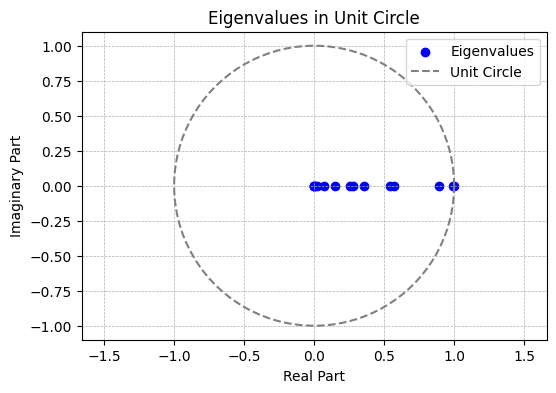

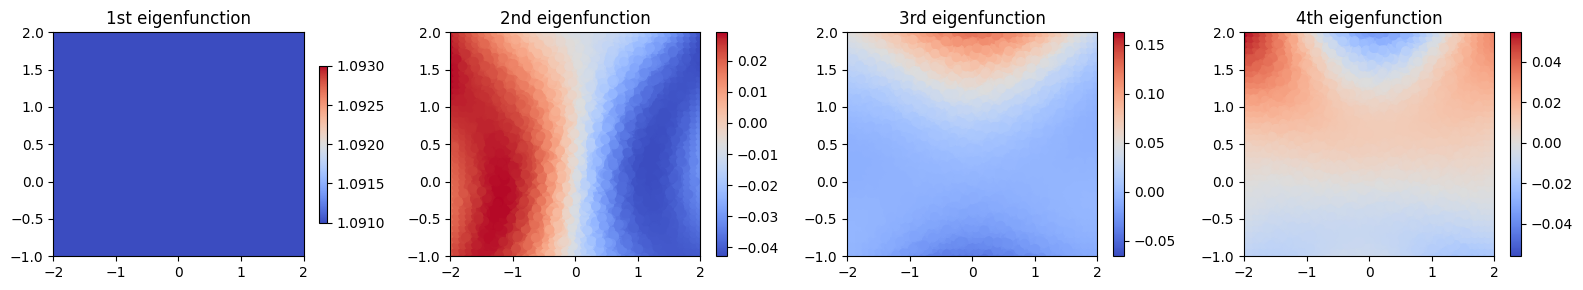

In [7]:
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues is a numpy array of complex numbers
print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])

plt.tight_layout()
plt.show()


In [8]:
# inner epoch = 50
# training step for fnn = 200